### Importing Necessary Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

### Setting device

In [2]:
!nvidia-smi

Fri Feb 16 22:04:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8               4W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataset

In [4]:
np.unique(sns.get_dataset_names()).tolist()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [5]:
# load_dataset() -> Loads an example dataset from the online repository, retuns datafram
df = sns.load_dataset('flights')
df.head(15)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
5,1949,Jun,135
6,1949,Jul,148
7,1949,Aug,148
8,1949,Sep,136
9,1949,Oct,119


In [6]:
df.tail()

,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


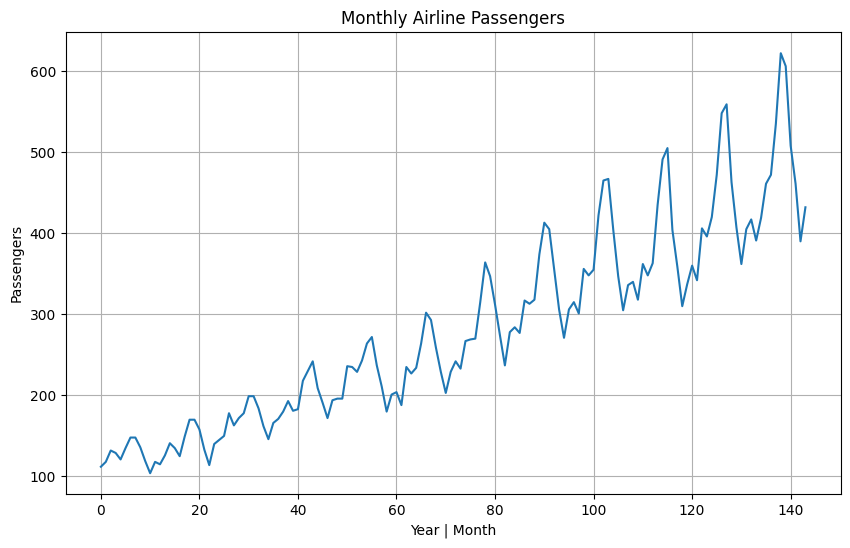

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['passengers'])
plt.title('Monthly Airline Passengers')
plt.xlabel('Year | Month')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

### Data Prepration for the learning

First we must convert string values to numerical values

In [8]:
passengers = df['passengers'].values.astype('float32')
passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Split data into train, validation, and test sets

In [9]:
train_size = int(0.7 * len(passengers))
val_size = int(0.15 * len(passengers))
test_size = len(passengers) - train_size - val_size
print(f"train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")

train_size: 100, val_size: 21, test_size: 23


In [10]:
train_data = passengers[:train_size].reshape(-1, 1)
valid_data = passengers[train_size:train_size + val_size].reshape(-1, 1)
test_data = passengers[train_size + val_size:].reshape(-1, 1)

Since LSTM is sensitive to the scale of the input data, we need to normalize it so that all input features have a similar scale and prevent some features from dominating the learning process.

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
valid_data_normalized = scaler.transform(valid_data)
test_data_normalized = scaler.transform(test_data)

We can use a many-to-many model to create our sequences.

In [12]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:i+seq_length+1])
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [13]:
seq_length = 8
train_seq = create_sequences(train_data_normalized, seq_length)
train_seq[0].shape, train_seq[1].shape

(torch.Size([92, 8, 1]), torch.Size([92, 8, 1]))

In [14]:
valid_seq = create_sequences(valid_data_normalized, seq_length)
test_seq = create_sequences(test_data_normalized, seq_length)

train_dataset = TensorDataset(train_seq[0], train_seq[1])
val_dataset = TensorDataset(valid_seq[0], valid_seq[1])
test_dataset = TensorDataset(test_seq[0], test_seq[1])

In [15]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)